# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift_2/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'],
                aug_window_size=config['fit']['aug_window_size'],
                aug_hop_size=config['fit']['aug_hop_size']
                )
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-08 01:15:09,735 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-08 01:15:09,736 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 01:15:10,708 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:21<00:00, 84.25it/s] 


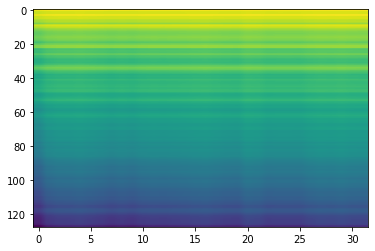

2020-11-08 01:15:54,399 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:121.551591, valid_AUC:0.500306, valid_pAUC:0.503564
100%|██████████| 1803/1803 [00:22<00:00, 81.86it/s]
2020-11-08 01:16:35,544 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:17.077129, valid_AUC:0.504396, valid_pAUC:0.507756
100%|██████████| 1803/1803 [00:20<00:00, 86.08it/s]
2020-11-08 01:17:15,703 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:16.669313, valid_AUC:0.500665, valid_pAUC:0.513345
100%|██████████| 1803/1803 [00:21<00:00, 85.82it/s]
2020-11-08 01:17:56,748 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:16.632860, valid_AUC:0.511311, valid_pAUC:0.513730
100%|██████████| 1803/1803 [00:21<00:00, 84.86it/s]
2020-11-08 01:18:36,929 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.521071, valid_AUC:0.500071, valid_pAUC:0.512689
100%|██████████| 1803/1803 [00:22<00:00, 79.74it/s]
2020-11-08 01:19:18,213 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:16.434395, valid_AUC:0

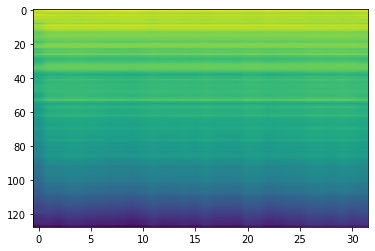

2020-11-08 01:21:59,155 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:14.545806, valid_AUC:0.500547, valid_pAUC:0.507822
100%|██████████| 1803/1803 [00:21<00:00, 85.08it/s]
2020-11-08 01:22:40,738 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:14.373741, valid_AUC:0.507395, valid_pAUC:0.504811
100%|██████████| 1803/1803 [00:20<00:00, 86.15it/s]
2020-11-08 01:23:20,747 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:14.096544, valid_AUC:0.510707, valid_pAUC:0.506809
100%|██████████| 1803/1803 [00:21<00:00, 83.26it/s]
2020-11-08 01:24:00,559 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:14.051999, valid_AUC:0.519119, valid_pAUC:0.509922
100%|██████████| 1803/1803 [00:21<00:00, 84.93it/s] 
2020-11-08 01:24:40,945 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:13.923354, valid_AUC:0.509710, valid_pAUC:0.506293
100%|██████████| 1803/1803 [00:20<00:00, 86.88it/s] 
2020-11-08 01:25:20,845 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:13.775170, vali

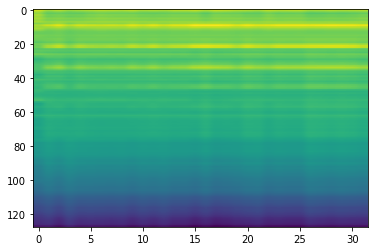

2020-11-08 01:28:40,326 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:13.480768, valid_AUC:0.521866, valid_pAUC:0.507672
100%|██████████| 1803/1803 [00:20<00:00, 85.86it/s]
2020-11-08 01:29:17,797 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:13.502463, valid_AUC:0.523521, valid_pAUC:0.504483
100%|██████████| 1803/1803 [00:20<00:00, 88.09it/s]
2020-11-08 01:29:56,030 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.198458, valid_AUC:0.543056, valid_pAUC:0.508187
100%|██████████| 1803/1803 [00:20<00:00, 88.01it/s]
2020-11-08 01:30:35,313 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:13.099089, valid_AUC:0.521907, valid_pAUC:0.502935
100%|██████████| 1803/1803 [00:20<00:00, 87.87it/s]
2020-11-08 01:31:14,546 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:13.090360, valid_AUC:0.527708, valid_pAUC:0.503779
100%|██████████| 1803/1803 [00:17<00:00, 105.09it/s]
2020-11-08 01:31:50,480 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:13.082417, valid

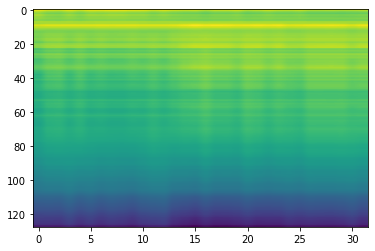

2020-11-08 01:33:55,450 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:12.788339, valid_AUC:0.526828, valid_pAUC:0.502738
100%|██████████| 1803/1803 [00:13<00:00, 131.86it/s]
2020-11-08 01:34:21,037 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.689407, valid_AUC:0.528672, valid_pAUC:0.502335
100%|██████████| 1803/1803 [00:13<00:00, 135.66it/s]
2020-11-08 01:34:46,158 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:12.815938, valid_AUC:0.526780, valid_pAUC:0.502964
100%|██████████| 1803/1803 [00:12<00:00, 146.10it/s]
2020-11-08 01:35:10,815 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:12.641108, valid_AUC:0.529561, valid_pAUC:0.502345
100%|██████████| 1803/1803 [00:11<00:00, 162.82it/s]
2020-11-08 01:35:34,408 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:12.654622, valid_AUC:0.528036, valid_pAUC:0.503226
100%|██████████| 1803/1803 [00:11<00:00, 150.65it/s]
2020-11-08 01:35:59,248 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:12.660022, v

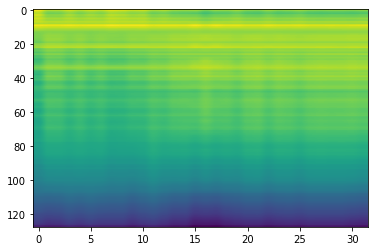

2020-11-08 01:38:03,932 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:12.548566, valid_AUC:0.527685, valid_pAUC:0.506124
100%|██████████| 1803/1803 [00:12<00:00, 148.66it/s]
2020-11-08 01:38:29,020 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:12.333871, valid_AUC:0.535123, valid_pAUC:0.507090
100%|██████████| 1803/1803 [00:13<00:00, 137.50it/s]
2020-11-08 01:38:54,353 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:12.438061, valid_AUC:0.540984, valid_pAUC:0.507250
100%|██████████| 1803/1803 [00:14<00:00, 128.08it/s]
2020-11-08 01:39:20,201 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:12.267288, valid_AUC:0.540084, valid_pAUC:0.506490
100%|██████████| 1803/1803 [00:12<00:00, 143.42it/s]
2020-11-08 01:39:44,888 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:12.135373, valid_AUC:0.542826, valid_pAUC:0.507287
100%|██████████| 1803/1803 [00:11<00:00, 156.20it/s]
2020-11-08 01:40:08,925 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:12.018263, v

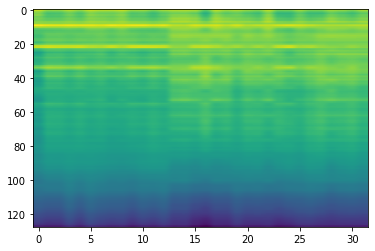

2020-11-08 01:42:14,424 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.470401, valid_AUC:0.544946, valid_pAUC:0.504971
100%|██████████| 1803/1803 [00:11<00:00, 158.55it/s]
2020-11-08 01:42:38,815 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.354845, valid_AUC:0.538860, valid_pAUC:0.505130
100%|██████████| 1803/1803 [00:11<00:00, 156.21it/s]
2020-11-08 01:43:03,104 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.283923, valid_AUC:0.545102, valid_pAUC:0.504830
100%|██████████| 1803/1803 [00:12<00:00, 141.95it/s]
2020-11-08 01:43:28,432 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.283945, valid_AUC:0.551222, valid_pAUC:0.503939
100%|██████████| 1803/1803 [00:14<00:00, 125.96it/s]
2020-11-08 01:43:54,544 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.229410, valid_AUC:0.552958, valid_pAUC:0.506546
100%|██████████| 1803/1803 [00:13<00:00, 133.46it/s]
2020-11-08 01:44:19,857 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.126047, v

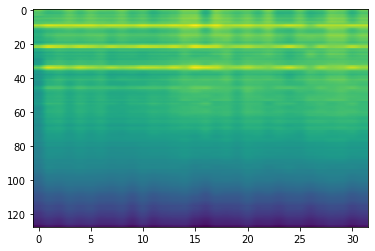

2020-11-08 01:46:24,412 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.888805, valid_AUC:0.555153, valid_pAUC:0.508272
100%|██████████| 1803/1803 [00:13<00:00, 133.46it/s]
2020-11-08 01:46:49,756 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.847094, valid_AUC:0.559143, valid_pAUC:0.512914
100%|██████████| 1803/1803 [00:12<00:00, 147.74it/s]
2020-11-08 01:47:14,149 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.829583, valid_AUC:0.554458, valid_pAUC:0.510607
100%|██████████| 1803/1803 [00:11<00:00, 162.91it/s]
2020-11-08 01:47:38,081 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.703595, valid_AUC:0.559795, valid_pAUC:0.509735
100%|██████████| 1803/1803 [00:11<00:00, 152.94it/s]
2020-11-08 01:48:02,855 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.684185, valid_AUC:0.559426, valid_pAUC:0.512661
100%|██████████| 1803/1803 [00:12<00:00, 142.05it/s]
2020-11-08 01:48:27,911 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.768300, v

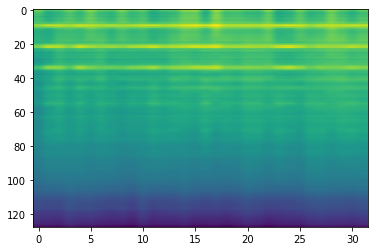

2020-11-08 01:50:33,029 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.665814, valid_AUC:0.555417, valid_pAUC:0.511442
100%|██████████| 1803/1803 [00:12<00:00, 141.69it/s]
2020-11-08 01:50:58,222 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.701590, valid_AUC:0.555123, valid_pAUC:0.509088
100%|██████████| 1803/1803 [00:14<00:00, 125.74it/s]
2020-11-08 01:51:24,388 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.588443, valid_AUC:0.561299, valid_pAUC:0.512426
100%|██████████| 1803/1803 [00:13<00:00, 137.33it/s]
2020-11-08 01:51:49,509 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.510878, valid_AUC:0.559645, valid_pAUC:0.510410
100%|██████████| 1803/1803 [00:11<00:00, 151.05it/s]
2020-11-08 01:52:13,772 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.531202, valid_AUC:0.566221, valid_pAUC:0.514265
100%|██████████| 1803/1803 [00:11<00:00, 162.70it/s]
2020-11-08 01:52:37,641 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.526137, v

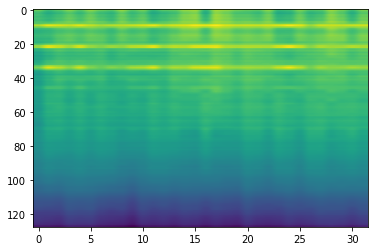

2020-11-08 01:54:47,607 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.547437, valid_AUC:0.572252, valid_pAUC:0.509979
100%|██████████| 1803/1803 [00:11<00:00, 152.41it/s]
2020-11-08 01:55:14,678 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.665632, valid_AUC:0.576017, valid_pAUC:0.509772
100%|██████████| 1803/1803 [00:13<00:00, 137.72it/s]
2020-11-08 01:55:41,096 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.478860, valid_AUC:0.570356, valid_pAUC:0.510373
100%|██████████| 1803/1803 [00:14<00:00, 123.44it/s]
2020-11-08 01:56:08,807 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.456345, valid_AUC:0.566048, valid_pAUC:0.510720
100%|██████████| 1803/1803 [00:14<00:00, 123.16it/s]
2020-11-08 01:56:35,872 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.393888, valid_AUC:0.564934, valid_pAUC:0.508647
100%|██████████| 1803/1803 [00:13<00:00, 135.19it/s]
2020-11-08 01:57:02,091 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.411134, v

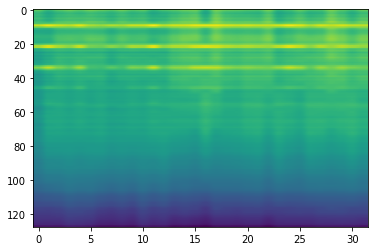

2020-11-08 01:59:54,084 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.347972, valid_AUC:0.570282, valid_pAUC:0.513833
100%|██████████| 1803/1803 [00:14<00:00, 124.41it/s]
2020-11-08 02:00:21,265 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.386082, valid_AUC:0.573934, valid_pAUC:0.510626
100%|██████████| 1803/1803 [00:13<00:00, 135.02it/s]
2020-11-08 02:00:47,513 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.285956, valid_AUC:0.573747, valid_pAUC:0.510260
100%|██████████| 1803/1803 [00:12<00:00, 138.90it/s]
2020-11-08 02:01:14,000 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.267754, valid_AUC:0.573707, valid_pAUC:0.512117
100%|██████████| 1803/1803 [00:13<00:00, 136.84it/s]
2020-11-08 02:01:40,457 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.317279, valid_AUC:0.572833, valid_pAUC:0.510823
100%|██████████| 1803/1803 [00:14<00:00, 125.25it/s]
2020-11-08 02:02:07,803 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.257302, v

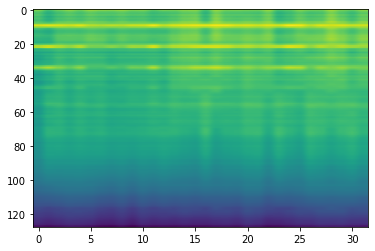

2020-11-08 02:04:18,101 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.167649, valid_AUC:0.567138, valid_pAUC:0.510026
2020-11-08 02:04:18,150 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift_2/models/fan_model.pth


elapsed time: 2948.416533709 [sec]


2020-11-08 02:04:18,702 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-08 02:04:18,703 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 02:04:18,705 - 00_train.py - INFO - TRAINING
  1%|          | 1/91 [00:00<00:11,  8.17it/s]

use: cuda:0


100%|██████████| 832/832 [00:06<00:00, 124.18it/s]


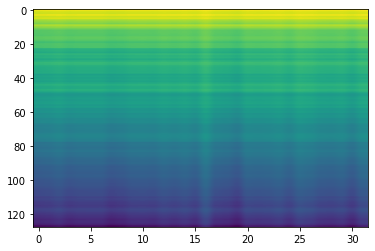

2020-11-08 02:04:37,904 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:129.436649, valid_AUC:0.504282, valid_pAUC:0.490162
100%|██████████| 832/832 [00:06<00:00, 127.68it/s]
2020-11-08 02:04:55,145 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:18.391930, valid_AUC:0.677425, valid_pAUC:0.553332
100%|██████████| 832/832 [00:05<00:00, 150.71it/s]
2020-11-08 02:05:11,793 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:18.243421, valid_AUC:0.670446, valid_pAUC:0.552936
100%|██████████| 832/832 [00:05<00:00, 154.83it/s]
2020-11-08 02:05:28,557 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:17.650378, valid_AUC:0.665602, valid_pAUC:0.548459
100%|██████████| 832/832 [00:06<00:00, 130.74it/s]
2020-11-08 02:05:45,974 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:17.630950, valid_AUC:0.681157, valid_pAUC:0.556317
100%|██████████| 832/832 [00:06<00:00, 130.69it/s]
2020-11-08 02:06:03,227 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:17.798536, valid_AUC:0.6704

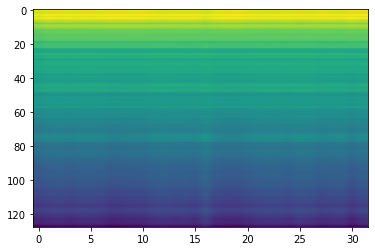

2020-11-08 02:07:12,000 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:17.600250, valid_AUC:0.646562, valid_pAUC:0.539596
100%|██████████| 832/832 [00:06<00:00, 127.20it/s]
2020-11-08 02:07:29,210 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:17.523082, valid_AUC:0.647344, valid_pAUC:0.537494
100%|██████████| 832/832 [00:05<00:00, 140.23it/s]
2020-11-08 02:07:46,103 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:17.463729, valid_AUC:0.659468, valid_pAUC:0.542794
100%|██████████| 832/832 [00:05<00:00, 162.52it/s]
2020-11-08 02:08:02,918 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:17.551876, valid_AUC:0.653420, valid_pAUC:0.541880
100%|██████████| 832/832 [00:05<00:00, 144.24it/s]
2020-11-08 02:08:20,221 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:17.726316, valid_AUC:0.654346, valid_pAUC:0.542855
100%|██████████| 832/832 [00:06<00:00, 134.03it/s]
2020-11-08 02:08:37,681 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:17.538042, valid_AUC:0

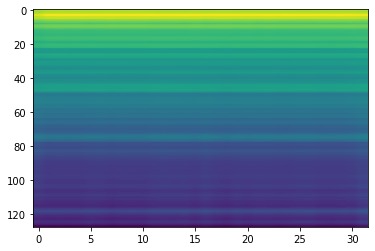

2020-11-08 02:10:03,763 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:17.199162, valid_AUC:0.725862, valid_pAUC:0.652534
100%|██████████| 832/832 [00:06<00:00, 135.52it/s]
2020-11-08 02:10:20,497 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:16.180846, valid_AUC:0.629763, valid_pAUC:0.546296
100%|██████████| 832/832 [00:05<00:00, 154.68it/s]
2020-11-08 02:10:37,307 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:15.801789, valid_AUC:0.631759, valid_pAUC:0.543799
100%|██████████| 832/832 [00:05<00:00, 146.98it/s]
2020-11-08 02:10:54,627 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:15.570358, valid_AUC:0.637344, valid_pAUC:0.542672
100%|██████████| 832/832 [00:06<00:00, 123.67it/s]
2020-11-08 02:11:12,547 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:15.527448, valid_AUC:0.636794, valid_pAUC:0.548642
100%|██████████| 832/832 [00:06<00:00, 126.91it/s]
2020-11-08 02:11:29,809 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:15.434789, valid_AUC:0

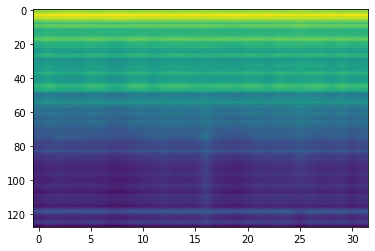

2020-11-08 02:12:56,397 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:14.993017, valid_AUC:0.643941, valid_pAUC:0.554794
100%|██████████| 832/832 [00:05<00:00, 138.91it/s]
2020-11-08 02:13:13,572 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:15.035541, valid_AUC:0.659375, valid_pAUC:0.548428
100%|██████████| 832/832 [00:05<00:00, 163.44it/s]
2020-11-08 02:13:30,129 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:15.132522, valid_AUC:0.666464, valid_pAUC:0.564784
100%|██████████| 832/832 [00:06<00:00, 138.34it/s]
2020-11-08 02:13:47,287 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:14.859690, valid_AUC:0.653403, valid_pAUC:0.548337
100%|██████████| 832/832 [00:06<00:00, 125.37it/s]
2020-11-08 02:14:05,019 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:14.770885, valid_AUC:0.642141, valid_pAUC:0.544773
100%|██████████| 832/832 [00:06<00:00, 128.31it/s]
2020-11-08 02:14:22,077 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:14.777305, valid_AUC:0

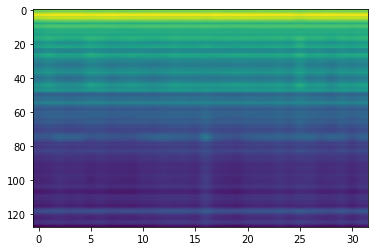

2020-11-08 02:15:49,243 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:14.436668, valid_AUC:0.639387, valid_pAUC:0.537159
100%|██████████| 832/832 [00:05<00:00, 151.62it/s]
2020-11-08 02:16:05,882 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:14.263892, valid_AUC:0.662506, valid_pAUC:0.546631
100%|██████████| 832/832 [00:05<00:00, 151.07it/s]
2020-11-08 02:16:22,872 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:14.106254, valid_AUC:0.661591, valid_pAUC:0.534022
100%|██████████| 832/832 [00:06<00:00, 129.74it/s]
2020-11-08 02:16:40,606 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:13.836850, valid_AUC:0.662014, valid_pAUC:0.551718
100%|██████████| 832/832 [00:06<00:00, 123.91it/s]
2020-11-08 02:16:58,186 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:13.668628, valid_AUC:0.652020, valid_pAUC:0.532560
100%|██████████| 832/832 [00:06<00:00, 136.76it/s]
2020-11-08 02:17:15,158 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:13.542821, valid_AUC:0

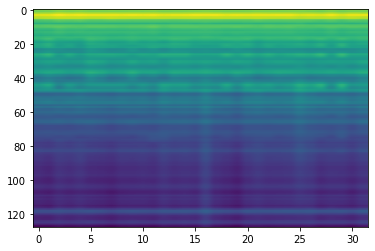

2020-11-08 02:18:41,103 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:13.133082, valid_AUC:0.670706, valid_pAUC:0.565576
100%|██████████| 832/832 [00:05<00:00, 159.14it/s]
2020-11-08 02:18:57,961 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:12.978035, valid_AUC:0.678220, valid_pAUC:0.563840
100%|██████████| 832/832 [00:05<00:00, 140.12it/s]
2020-11-08 02:19:15,587 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:13.025280, valid_AUC:0.687529, valid_pAUC:0.586958
100%|██████████| 832/832 [00:06<00:00, 129.96it/s]
2020-11-08 02:19:33,115 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:12.950777, valid_AUC:0.669485, valid_pAUC:0.559728
100%|██████████| 832/832 [00:06<00:00, 128.71it/s]
2020-11-08 02:19:50,557 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:12.763833, valid_AUC:0.694115, valid_pAUC:0.591770
100%|██████████| 832/832 [00:05<00:00, 148.69it/s]
2020-11-08 02:20:07,486 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:12.788469, valid_AUC:0

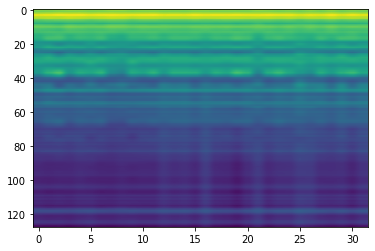

2020-11-08 02:21:33,780 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:12.472710, valid_AUC:0.667135, valid_pAUC:0.555586
100%|██████████| 832/832 [00:05<00:00, 143.78it/s]
2020-11-08 02:21:51,132 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:12.342853, valid_AUC:0.678420, valid_pAUC:0.560855
100%|██████████| 832/832 [00:06<00:00, 127.78it/s]
2020-11-08 02:22:08,741 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:12.305446, valid_AUC:0.670069, valid_pAUC:0.553972
100%|██████████| 832/832 [00:06<00:00, 124.76it/s]
2020-11-08 02:22:26,190 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:12.185383, valid_AUC:0.663160, valid_pAUC:0.545565
100%|██████████| 832/832 [00:06<00:00, 129.93it/s]
2020-11-08 02:22:43,794 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:12.187129, valid_AUC:0.661626, valid_pAUC:0.542367
100%|██████████| 832/832 [00:05<00:00, 156.92it/s]
2020-11-08 02:23:00,546 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:12.235541, valid_AUC:0

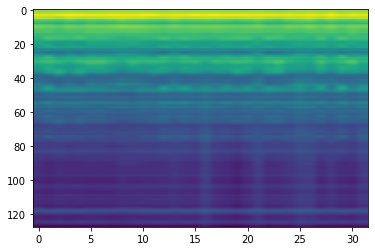

2020-11-08 02:24:26,236 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:12.061972, valid_AUC:0.691128, valid_pAUC:0.568713
100%|██████████| 832/832 [00:05<00:00, 140.09it/s]
2020-11-08 02:24:44,091 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:12.190466, valid_AUC:0.663061, valid_pAUC:0.544926
100%|██████████| 832/832 [00:06<00:00, 126.46it/s]
2020-11-08 02:25:01,770 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.951609, valid_AUC:0.671267, valid_pAUC:0.549860
100%|██████████| 832/832 [00:06<00:00, 122.94it/s]
2020-11-08 02:25:19,518 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:12.010894, valid_AUC:0.674838, valid_pAUC:0.550317
100%|██████████| 832/832 [00:06<00:00, 134.15it/s]
2020-11-08 02:25:36,838 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.923608, valid_AUC:0.682413, valid_pAUC:0.561586
100%|██████████| 832/832 [00:05<00:00, 156.50it/s]
2020-11-08 02:25:53,584 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.901606, valid_AUC:0

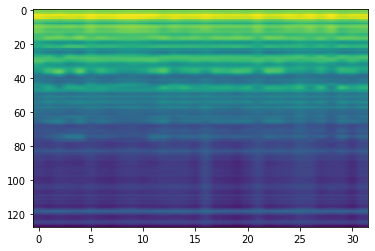

2020-11-08 02:27:20,275 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.706722, valid_AUC:0.679855, valid_pAUC:0.551779
100%|██████████| 832/832 [00:05<00:00, 140.72it/s]
2020-11-08 02:27:37,782 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.745246, valid_AUC:0.666238, valid_pAUC:0.549982
100%|██████████| 832/832 [00:06<00:00, 132.04it/s]
2020-11-08 02:27:55,400 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.874437, valid_AUC:0.681505, valid_pAUC:0.558480
100%|██████████| 832/832 [00:06<00:00, 126.38it/s]
2020-11-08 02:28:12,785 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:11.743264, valid_AUC:0.682772, valid_pAUC:0.560977
100%|██████████| 832/832 [00:05<00:00, 139.29it/s]
2020-11-08 02:28:30,030 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:11.898974, valid_AUC:0.665648, valid_pAUC:0.543190
100%|██████████| 832/832 [00:05<00:00, 162.02it/s]
2020-11-08 02:28:46,593 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:11.692528, valid_AUC:0

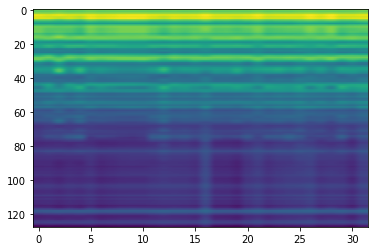

2020-11-08 02:30:12,928 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.499898, valid_AUC:0.679016, valid_pAUC:0.550225
100%|██████████| 832/832 [00:06<00:00, 130.74it/s]
2020-11-08 02:30:30,721 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:11.557257, valid_AUC:0.675961, valid_pAUC:0.548337
100%|██████████| 832/832 [00:06<00:00, 124.96it/s]
2020-11-08 02:30:48,062 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:11.554829, valid_AUC:0.668634, valid_pAUC:0.549342
100%|██████████| 832/832 [00:06<00:00, 128.50it/s]
2020-11-08 02:31:05,445 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:11.541370, valid_AUC:0.678576, valid_pAUC:0.535971
100%|██████████| 832/832 [00:05<00:00, 150.77it/s]
2020-11-08 02:31:22,586 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:11.409142, valid_AUC:0.673038, valid_pAUC:0.552144
100%|██████████| 832/832 [00:05<00:00, 148.67it/s]
2020-11-08 02:31:39,770 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:11.390972, valid_AUC:0

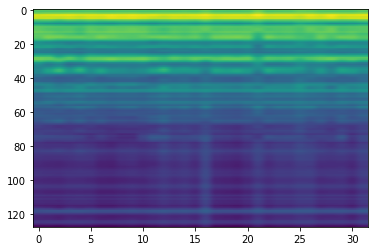

2020-11-08 02:33:07,036 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:11.220373, valid_AUC:0.686626, valid_pAUC:0.550774
2020-11-08 02:33:07,082 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift_2/models/pump_model.pth


elapsed time: 1728.381635904 [sec]


2020-11-08 02:33:07,679 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-08 02:33:07,680 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 02:33:07,682 - 00_train.py - INFO - TRAINING
  0%|          | 0/81 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:15<00:00, 79.89it/s]


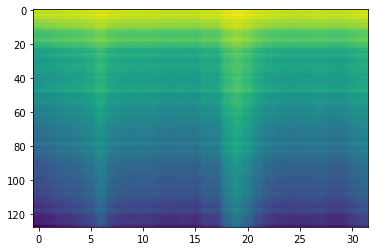

2020-11-08 02:34:21,842 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:160.816796, valid_AUC:0.569554, valid_pAUC:0.504759
100%|██████████| 1246/1246 [00:09<00:00, 128.55it/s]
2020-11-08 02:34:41,721 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:20.273598, valid_AUC:0.561764, valid_pAUC:0.498880
100%|██████████| 1246/1246 [00:09<00:00, 126.51it/s]
2020-11-08 02:35:01,027 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:19.891113, valid_AUC:0.553032, valid_pAUC:0.491772
100%|██████████| 1246/1246 [00:09<00:00, 125.89it/s]
2020-11-08 02:35:20,689 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:19.485926, valid_AUC:0.550588, valid_pAUC:0.489035
100%|██████████| 1246/1246 [00:09<00:00, 132.27it/s]
2020-11-08 02:35:39,908 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:19.315924, valid_AUC:0.559728, valid_pAUC:0.491944
100%|██████████| 1246/1246 [00:08<00:00, 155.07it/s]
2020-11-08 02:35:58,017 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:19.226202, valid_

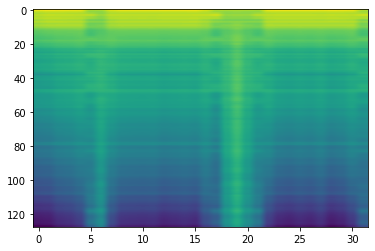

2020-11-08 02:37:13,443 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:18.293235, valid_AUC:0.524439, valid_pAUC:0.491057
100%|██████████| 1246/1246 [00:08<00:00, 140.40it/s]
2020-11-08 02:37:31,800 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:17.853549, valid_AUC:0.588620, valid_pAUC:0.503235
100%|██████████| 1246/1246 [00:08<00:00, 152.53it/s]
2020-11-08 02:37:49,990 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:17.710794, valid_AUC:0.581918, valid_pAUC:0.503717
100%|██████████| 1246/1246 [00:07<00:00, 157.62it/s]
2020-11-08 02:38:07,896 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:17.388880, valid_AUC:0.598777, valid_pAUC:0.505615
100%|██████████| 1246/1246 [00:08<00:00, 142.80it/s]
2020-11-08 02:38:26,671 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:17.345288, valid_AUC:0.575263, valid_pAUC:0.505335
100%|██████████| 1246/1246 [00:09<00:00, 128.80it/s]
2020-11-08 02:38:46,083 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:17.137777, v

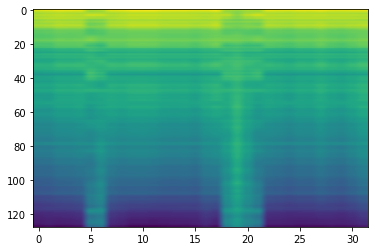

2020-11-08 02:40:19,397 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:15.795641, valid_AUC:0.601303, valid_pAUC:0.499549
100%|██████████| 1246/1246 [00:09<00:00, 126.54it/s]
2020-11-08 02:40:38,833 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:15.602405, valid_AUC:0.608437, valid_pAUC:0.503437
100%|██████████| 1246/1246 [00:09<00:00, 131.93it/s]
2020-11-08 02:40:57,627 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:15.278667, valid_AUC:0.643508, valid_pAUC:0.508181
100%|██████████| 1246/1246 [00:08<00:00, 148.37it/s]
2020-11-08 02:41:16,043 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:15.211165, valid_AUC:0.630827, valid_pAUC:0.504230
100%|██████████| 1246/1246 [00:07<00:00, 163.74it/s]
2020-11-08 02:41:33,738 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:15.161876, valid_AUC:0.649164, valid_pAUC:0.512256
100%|██████████| 1246/1246 [00:08<00:00, 146.61it/s]
2020-11-08 02:41:52,472 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:14.893677, v

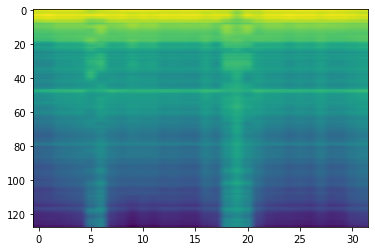

2020-11-08 02:43:26,433 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:14.664127, valid_AUC:0.665428, valid_pAUC:0.515320
100%|██████████| 1246/1246 [00:08<00:00, 141.87it/s]
2020-11-08 02:43:45,170 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:14.666274, valid_AUC:0.653853, valid_pAUC:0.512707
100%|██████████| 1246/1246 [00:09<00:00, 126.16it/s]
2020-11-08 02:44:04,911 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:14.618897, valid_AUC:0.662866, valid_pAUC:0.519130
100%|██████████| 1246/1246 [00:09<00:00, 132.09it/s]
2020-11-08 02:44:23,747 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:14.681482, valid_AUC:0.658614, valid_pAUC:0.514822
100%|██████████| 1246/1246 [00:08<00:00, 147.32it/s]
2020-11-08 02:44:42,196 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:14.590824, valid_AUC:0.659391, valid_pAUC:0.513267
100%|██████████| 1246/1246 [00:07<00:00, 161.83it/s]
2020-11-08 02:45:00,063 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:14.404611, v

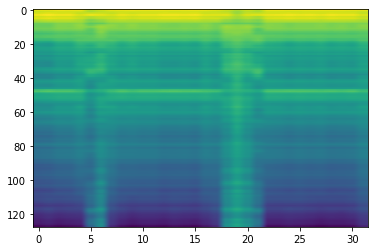

2020-11-08 02:46:33,688 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:14.335890, valid_AUC:0.658088, valid_pAUC:0.515740
100%|██████████| 1246/1246 [00:07<00:00, 156.73it/s]
2020-11-08 02:46:52,023 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:14.231813, valid_AUC:0.661209, valid_pAUC:0.513656
100%|██████████| 1246/1246 [00:08<00:00, 143.10it/s]
2020-11-08 02:47:10,676 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:14.128196, valid_AUC:0.669826, valid_pAUC:0.525709
100%|██████████| 1246/1246 [00:09<00:00, 127.33it/s]
2020-11-08 02:47:30,213 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:14.085643, valid_AUC:0.653644, valid_pAUC:0.512940
100%|██████████| 1246/1246 [00:09<00:00, 132.49it/s]
2020-11-08 02:47:48,973 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:13.895353, valid_AUC:0.674072, valid_pAUC:0.521463
100%|██████████| 1246/1246 [00:08<00:00, 151.45it/s]
2020-11-08 02:48:06,921 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:14.172373, v

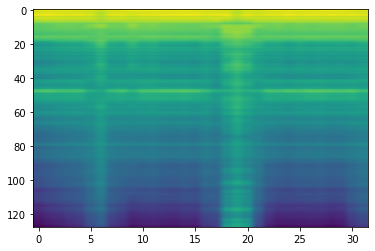

2020-11-08 02:49:40,452 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:13.437654, valid_AUC:0.683543, valid_pAUC:0.523936
100%|██████████| 1246/1246 [00:07<00:00, 156.97it/s]
2020-11-08 02:49:58,596 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:13.365010, valid_AUC:0.680201, valid_pAUC:0.522614
100%|██████████| 1246/1246 [00:08<00:00, 154.17it/s]
2020-11-08 02:50:16,973 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:13.232675, valid_AUC:0.689716, valid_pAUC:0.521494
100%|██████████| 1246/1246 [00:08<00:00, 139.72it/s]
2020-11-08 02:50:35,830 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:13.164699, valid_AUC:0.686209, valid_pAUC:0.519068
100%|██████████| 1246/1246 [00:10<00:00, 123.82it/s]
2020-11-08 02:50:55,337 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:12.976356, valid_AUC:0.685340, valid_pAUC:0.523734
100%|██████████| 1246/1246 [00:09<00:00, 131.99it/s]
2020-11-08 02:51:14,216 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:12.895308, v

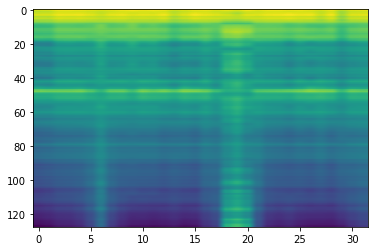

2020-11-08 02:52:47,262 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:12.494508, valid_AUC:0.688094, valid_pAUC:0.528011
100%|██████████| 1246/1246 [00:08<00:00, 140.45it/s]
2020-11-08 02:53:05,830 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:12.547828, valid_AUC:0.701303, valid_pAUC:0.536783
100%|██████████| 1246/1246 [00:07<00:00, 156.89it/s]
2020-11-08 02:53:23,951 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:12.374953, valid_AUC:0.678446, valid_pAUC:0.531915
100%|██████████| 1246/1246 [00:08<00:00, 153.90it/s]
2020-11-08 02:53:42,439 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:12.264418, valid_AUC:0.690452, valid_pAUC:0.531277
100%|██████████| 1246/1246 [00:08<00:00, 141.00it/s]
2020-11-08 02:54:01,347 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:12.171264, valid_AUC:0.693924, valid_pAUC:0.528524
100%|██████████| 1246/1246 [00:09<00:00, 128.57it/s]
2020-11-08 02:54:20,638 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:12.126817, v

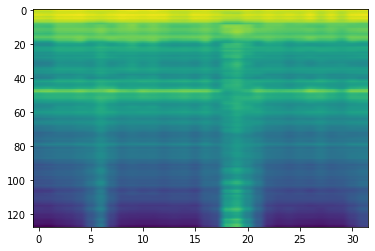

2020-11-08 02:55:53,334 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:12.003819, valid_AUC:0.692612, valid_pAUC:0.530966
100%|██████████| 1246/1246 [00:09<00:00, 129.86it/s]
2020-11-08 02:56:12,141 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:11.940927, valid_AUC:0.698915, valid_pAUC:0.534590
100%|██████████| 1246/1246 [00:08<00:00, 141.38it/s]
2020-11-08 02:56:30,598 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.885018, valid_AUC:0.702482, valid_pAUC:0.534870
100%|██████████| 1246/1246 [00:07<00:00, 159.77it/s]
2020-11-08 02:56:48,571 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.862507, valid_AUC:0.703658, valid_pAUC:0.533999
100%|██████████| 1246/1246 [00:08<00:00, 154.02it/s]
2020-11-08 02:57:06,875 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.833344, valid_AUC:0.707952, valid_pAUC:0.543378
100%|██████████| 1246/1246 [00:09<00:00, 136.87it/s]
2020-11-08 02:57:25,962 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.760215, v

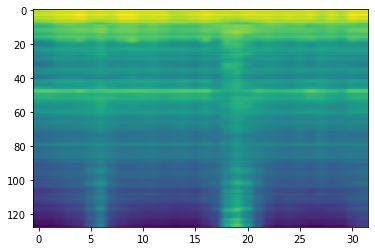

2020-11-08 02:58:59,448 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.643887, valid_AUC:0.703917, valid_pAUC:0.533781
100%|██████████| 1246/1246 [00:09<00:00, 131.42it/s]
2020-11-08 02:59:18,727 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.537995, valid_AUC:0.716395, valid_pAUC:0.540080
100%|██████████| 1246/1246 [00:09<00:00, 127.78it/s]
2020-11-08 02:59:37,806 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.444825, valid_AUC:0.716460, valid_pAUC:0.544326
100%|██████████| 1246/1246 [00:09<00:00, 134.06it/s]
2020-11-08 02:59:56,783 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:11.381447, valid_AUC:0.708189, valid_pAUC:0.539971
100%|██████████| 1246/1246 [00:07<00:00, 156.18it/s]
2020-11-08 03:00:14,949 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:11.359307, valid_AUC:0.711959, valid_pAUC:0.545291
100%|██████████| 1246/1246 [00:08<00:00, 154.84it/s]
2020-11-08 03:00:33,029 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:11.254950, v

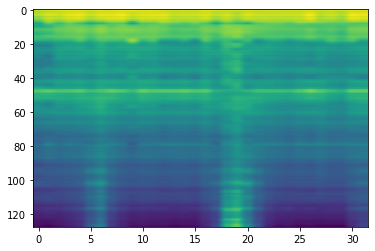

2020-11-08 03:02:07,336 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.042932, valid_AUC:0.718165, valid_pAUC:0.548230
100%|██████████| 1246/1246 [00:08<00:00, 154.29it/s]
2020-11-08 03:02:26,127 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.960312, valid_AUC:0.719249, valid_pAUC:0.548681
100%|██████████| 1246/1246 [00:09<00:00, 138.34it/s]
2020-11-08 03:02:45,201 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:11.094084, valid_AUC:0.733756, valid_pAUC:0.555493
100%|██████████| 1246/1246 [00:09<00:00, 126.58it/s]
2020-11-08 03:03:04,802 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.979133, valid_AUC:0.733262, valid_pAUC:0.555587
100%|██████████| 1246/1246 [00:09<00:00, 135.40it/s]
2020-11-08 03:03:23,365 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.926331, valid_AUC:0.719019, valid_pAUC:0.544606
100%|██████████| 1246/1246 [00:08<00:00, 147.61it/s]
2020-11-08 03:03:41,719 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.866302, v

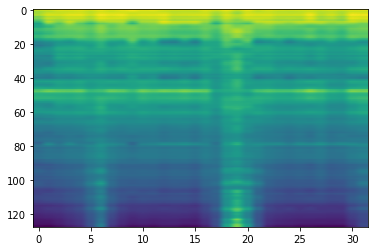

2020-11-08 03:05:16,074 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.770076, valid_AUC:0.728496, valid_pAUC:0.553783
2020-11-08 03:05:16,138 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift_2/models/slider_model.pth


elapsed time: 1928.460911036 [sec]


2020-11-08 03:05:16,868 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-08 03:05:16,870 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 03:05:16,874 - 00_train.py - INFO - TRAINING
  0%|          | 0/110 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:30<00:00, 79.30it/s]


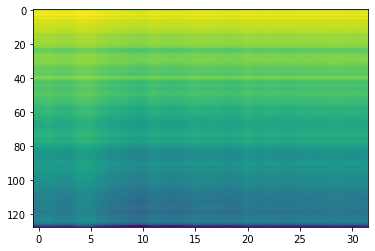

2020-11-08 03:07:11,197 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:114.296355, valid_AUC:0.587319, valid_pAUC:0.518424
100%|██████████| 2407/2407 [00:16<00:00, 141.81it/s]
2020-11-08 03:07:55,061 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:16.184113, valid_AUC:0.584955, valid_pAUC:0.517177
100%|██████████| 2407/2407 [00:16<00:00, 144.47it/s]
2020-11-08 03:08:26,101 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:16.205907, valid_AUC:0.583160, valid_pAUC:0.515583
100%|██████████| 2407/2407 [00:17<00:00, 137.60it/s]
2020-11-08 03:08:57,297 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:15.972340, valid_AUC:0.587134, valid_pAUC:0.516131
100%|██████████| 2407/2407 [00:17<00:00, 140.67it/s]
2020-11-08 03:09:28,008 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:15.952177, valid_AUC:0.587973, valid_pAUC:0.516949
100%|██████████| 2407/2407 [00:17<00:00, 139.09it/s]
2020-11-08 03:09:59,552 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:16.043282, valid_

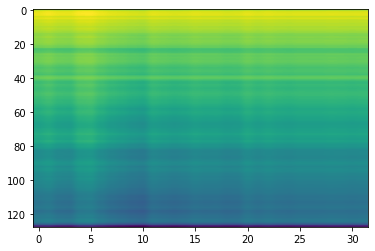

2020-11-08 03:12:03,674 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:15.901153, valid_AUC:0.590633, valid_pAUC:0.515833
100%|██████████| 2407/2407 [00:16<00:00, 144.17it/s]
2020-11-08 03:12:34,384 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:15.875620, valid_AUC:0.588854, valid_pAUC:0.517337
100%|██████████| 2407/2407 [00:17<00:00, 137.54it/s]
2020-11-08 03:13:05,673 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:15.884134, valid_AUC:0.580432, valid_pAUC:0.515930
100%|██████████| 2407/2407 [00:16<00:00, 142.36it/s]
2020-11-08 03:13:36,431 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:15.892711, valid_AUC:0.584667, valid_pAUC:0.516744
100%|██████████| 2407/2407 [00:17<00:00, 136.85it/s]
2020-11-08 03:14:08,202 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:15.974225, valid_AUC:0.576560, valid_pAUC:0.516389
100%|██████████| 2407/2407 [00:18<00:00, 133.67it/s]
2020-11-08 03:14:39,566 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:15.837483, v

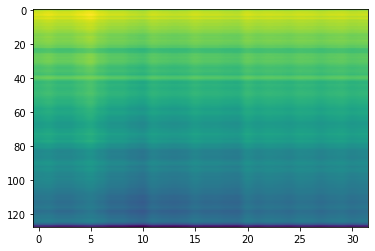

2020-11-08 03:17:13,045 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:15.789321, valid_AUC:0.591153, valid_pAUC:0.508732
100%|██████████| 2407/2407 [00:15<00:00, 158.90it/s]
2020-11-08 03:17:42,651 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:15.415820, valid_AUC:0.599303, valid_pAUC:0.529847
100%|██████████| 2407/2407 [00:16<00:00, 147.86it/s]
2020-11-08 03:18:13,174 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:15.218467, valid_AUC:0.601644, valid_pAUC:0.521937
100%|██████████| 2407/2407 [00:17<00:00, 136.58it/s]
2020-11-08 03:18:44,425 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:14.883040, valid_AUC:0.644472, valid_pAUC:0.532528
100%|██████████| 2407/2407 [00:18<00:00, 129.21it/s]
2020-11-08 03:19:16,247 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:14.690329, valid_AUC:0.632594, valid_pAUC:0.524177
100%|██████████| 2407/2407 [00:17<00:00, 138.35it/s]
2020-11-08 03:19:46,666 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:14.519845, v

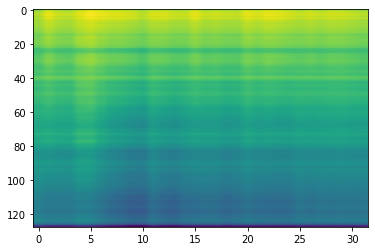

2020-11-08 03:22:18,449 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:12.934837, valid_AUC:0.673945, valid_pAUC:0.546498
100%|██████████| 2407/2407 [00:17<00:00, 137.36it/s]
2020-11-08 03:22:49,195 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.906161, valid_AUC:0.645374, valid_pAUC:0.532300
100%|██████████| 2407/2407 [00:16<00:00, 147.00it/s]
2020-11-08 03:23:19,263 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:12.844047, valid_AUC:0.666393, valid_pAUC:0.538692
100%|██████████| 2407/2407 [00:15<00:00, 158.15it/s]
2020-11-08 03:23:48,650 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:12.820780, valid_AUC:0.676394, valid_pAUC:0.549249
100%|██████████| 2407/2407 [00:15<00:00, 157.78it/s]
2020-11-08 03:24:19,140 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:12.853142, valid_AUC:0.648232, valid_pAUC:0.541114
100%|██████████| 2407/2407 [00:16<00:00, 147.06it/s]
2020-11-08 03:24:50,134 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:12.679270, v

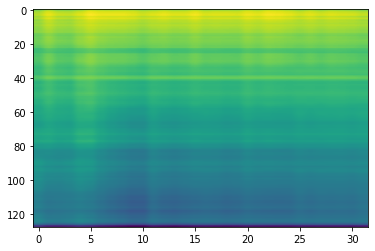

2020-11-08 03:27:23,411 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:12.580048, valid_AUC:0.666705, valid_pAUC:0.550616
100%|██████████| 2407/2407 [00:15<00:00, 154.24it/s]
2020-11-08 03:27:53,320 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:12.560629, valid_AUC:0.682341, valid_pAUC:0.553990
100%|██████████| 2407/2407 [00:16<00:00, 142.24it/s]
2020-11-08 03:28:24,233 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:12.575250, valid_AUC:0.637289, valid_pAUC:0.536773
100%|██████████| 2407/2407 [00:18<00:00, 132.56it/s]
2020-11-08 03:28:55,714 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:12.198013, valid_AUC:0.621221, valid_pAUC:0.532226
100%|██████████| 2407/2407 [00:17<00:00, 138.35it/s]
2020-11-08 03:29:26,287 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.927113, valid_AUC:0.625554, valid_pAUC:0.538191
100%|██████████| 2407/2407 [00:16<00:00, 145.00it/s]
2020-11-08 03:29:56,401 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.849520, v

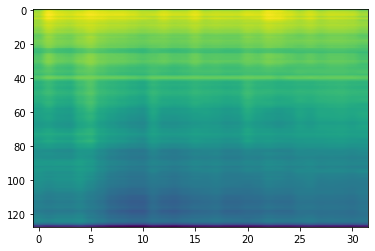

2020-11-08 03:32:29,356 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.658587, valid_AUC:0.643111, valid_pAUC:0.541589
100%|██████████| 2407/2407 [00:16<00:00, 141.97it/s]
2020-11-08 03:32:59,627 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.622441, valid_AUC:0.640423, valid_pAUC:0.547487
100%|██████████| 2407/2407 [00:15<00:00, 152.16it/s]
2020-11-08 03:33:29,403 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.539743, valid_AUC:0.640626, valid_pAUC:0.543239
100%|██████████| 2407/2407 [00:15<00:00, 160.37it/s]
2020-11-08 03:33:59,001 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.569339, valid_AUC:0.634521, valid_pAUC:0.539976
100%|██████████| 2407/2407 [00:15<00:00, 150.91it/s]
2020-11-08 03:34:29,684 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.444951, valid_AUC:0.621451, valid_pAUC:0.536847
100%|██████████| 2407/2407 [00:17<00:00, 138.98it/s]
2020-11-08 03:35:01,065 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.490217, v

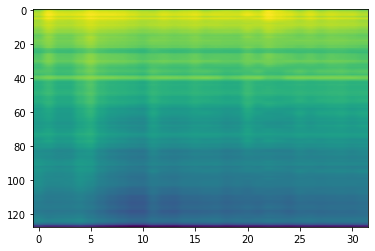

2020-11-08 03:37:33,910 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:11.330640, valid_AUC:0.629489, valid_pAUC:0.546039
100%|██████████| 2407/2407 [00:16<00:00, 144.56it/s]
2020-11-08 03:38:04,842 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:11.291668, valid_AUC:0.667822, valid_pAUC:0.562062
100%|██████████| 2407/2407 [00:18<00:00, 132.85it/s]
2020-11-08 03:38:36,430 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:11.167934, valid_AUC:0.630026, valid_pAUC:0.544105
100%|██████████| 2407/2407 [00:18<00:00, 129.68it/s]
2020-11-08 03:39:08,188 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:11.103832, valid_AUC:0.674194, valid_pAUC:0.572750
100%|██████████| 2407/2407 [00:17<00:00, 140.83it/s]
2020-11-08 03:39:38,640 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.991463, valid_AUC:0.658128, valid_pAUC:0.564324
100%|██████████| 2407/2407 [00:15<00:00, 152.68it/s]
2020-11-08 03:40:08,481 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.951897, v

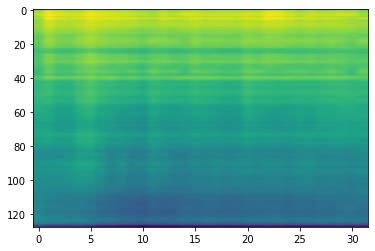

2020-11-08 03:42:42,069 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.796867, valid_AUC:0.642073, valid_pAUC:0.551829
100%|██████████| 2407/2407 [00:16<00:00, 148.14it/s]
2020-11-08 03:43:12,078 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.764930, valid_AUC:0.664628, valid_pAUC:0.557481
100%|██████████| 2407/2407 [00:15<00:00, 158.03it/s]
2020-11-08 03:43:41,718 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.754217, valid_AUC:0.650058, valid_pAUC:0.557044
100%|██████████| 2407/2407 [00:15<00:00, 157.31it/s]
2020-11-08 03:44:11,573 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.650856, valid_AUC:0.645705, valid_pAUC:0.550477
100%|██████████| 2407/2407 [00:16<00:00, 146.96it/s]
2020-11-08 03:44:42,294 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.685434, valid_AUC:0.643811, valid_pAUC:0.550821
100%|██████████| 2407/2407 [00:18<00:00, 133.49it/s]
2020-11-08 03:45:14,030 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.649028, v

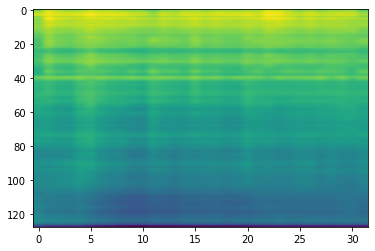

2020-11-08 03:47:45,685 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.495389, valid_AUC:0.641865, valid_pAUC:0.554147
100%|██████████| 2407/2407 [00:17<00:00, 138.79it/s]
2020-11-08 03:48:17,139 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.594287, valid_AUC:0.641593, valid_pAUC:0.552340
100%|██████████| 2407/2407 [00:18<00:00, 130.87it/s]
2020-11-08 03:48:48,786 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.467633, valid_AUC:0.646541, valid_pAUC:0.551269
100%|██████████| 2407/2407 [00:17<00:00, 137.77it/s]
2020-11-08 03:49:19,582 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.425615, valid_AUC:0.659201, valid_pAUC:0.558762
100%|██████████| 2407/2407 [00:16<00:00, 148.56it/s]
2020-11-08 03:49:49,673 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.400869, valid_AUC:0.643628, valid_pAUC:0.547924
100%|██████████| 2407/2407 [00:14<00:00, 160.86it/s]
2020-11-08 03:50:19,023 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.388247, v

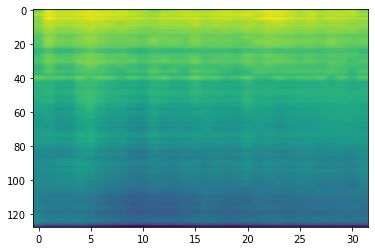

2020-11-08 03:52:53,844 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.301689, valid_AUC:0.664703, valid_pAUC:0.558172
100%|██████████| 2407/2407 [00:15<00:00, 157.39it/s]
2020-11-08 03:53:23,480 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.360027, valid_AUC:0.654683, valid_pAUC:0.551792
100%|██████████| 2407/2407 [00:15<00:00, 158.02it/s]
2020-11-08 03:53:53,527 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.419233, valid_AUC:0.638515, valid_pAUC:0.549313
100%|██████████| 2407/2407 [00:16<00:00, 147.54it/s]
2020-11-08 03:54:24,068 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.300652, valid_AUC:0.674693, valid_pAUC:0.562790
100%|██████████| 2407/2407 [00:17<00:00, 136.99it/s]
2020-11-08 03:54:55,380 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.226650, valid_AUC:0.667042, valid_pAUC:0.559023
100%|██████████| 2407/2407 [00:18<00:00, 131.73it/s]
2020-11-08 03:55:26,910 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.219071, v

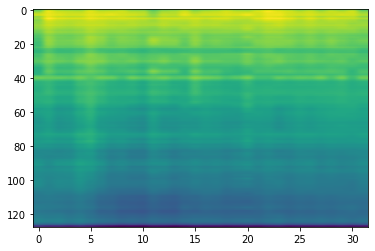

2020-11-08 03:57:58,674 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.092935, valid_AUC:0.663578, valid_pAUC:0.554375
2020-11-08 03:57:58,720 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift_2/models/ToyCar_model.pth


elapsed time: 3161.852387905 [sec]


2020-11-08 03:57:59,268 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-08 03:57:59,269 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 03:57:59,271 - 00_train.py - INFO - TRAINING
  0%|          | 0/94 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:40<00:00, 84.94it/s]


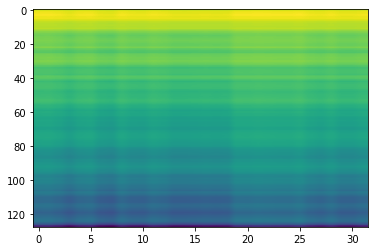

2020-11-08 03:59:50,312 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:78.377890, valid_AUC:0.535847, valid_pAUC:0.505588
100%|██████████| 3452/3452 [00:25<00:00, 136.11it/s]
2020-11-08 04:00:46,757 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:17.042848, valid_AUC:0.536991, valid_pAUC:0.505105
100%|██████████| 3452/3452 [00:24<00:00, 138.67it/s]
2020-11-08 04:01:22,424 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:16.907670, valid_AUC:0.519547, valid_pAUC:0.505815
100%|██████████| 3452/3452 [00:25<00:00, 138.08it/s]
2020-11-08 04:01:58,364 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:16.965211, valid_AUC:0.525788, valid_pAUC:0.506472
100%|██████████| 3452/3452 [00:24<00:00, 138.81it/s]
2020-11-08 04:02:34,181 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.914913, valid_AUC:0.537213, valid_pAUC:0.505572
100%|██████████| 3452/3452 [00:25<00:00, 136.63it/s]
2020-11-08 04:03:10,458 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:16.898320, valid_A

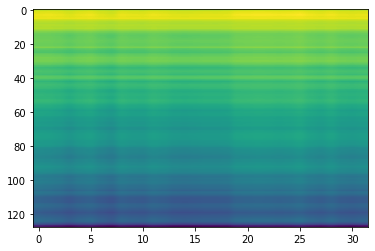

2020-11-08 04:05:33,952 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:16.794782, valid_AUC:0.535127, valid_pAUC:0.505570
100%|██████████| 3452/3452 [00:25<00:00, 137.08it/s]
2020-11-08 04:06:09,862 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:16.827015, valid_AUC:0.541675, valid_pAUC:0.504618
100%|██████████| 3452/3452 [00:25<00:00, 136.65it/s]
2020-11-08 04:06:45,930 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:16.829463, valid_AUC:0.542440, valid_pAUC:0.505064
100%|██████████| 3452/3452 [00:25<00:00, 137.46it/s]
2020-11-08 04:07:22,030 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:16.848626, valid_AUC:0.534359, valid_pAUC:0.505803
100%|██████████| 3452/3452 [00:25<00:00, 136.57it/s]
2020-11-08 04:07:58,065 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:16.788166, valid_AUC:0.540609, valid_pAUC:0.505430
100%|██████████| 3452/3452 [00:25<00:00, 136.69it/s]
2020-11-08 04:08:34,055 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:16.828840, v

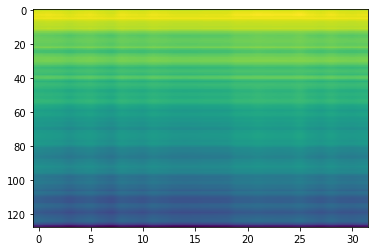

2020-11-08 04:11:34,639 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:16.736288, valid_AUC:0.542465, valid_pAUC:0.505124
100%|██████████| 3452/3452 [00:25<00:00, 136.75it/s]
2020-11-08 04:12:10,697 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:16.574265, valid_AUC:0.546671, valid_pAUC:0.505829
100%|██████████| 3452/3452 [00:25<00:00, 135.84it/s]
2020-11-08 04:12:47,047 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:16.717613, valid_AUC:0.549313, valid_pAUC:0.505652
100%|██████████| 3452/3452 [00:25<00:00, 137.61it/s]
2020-11-08 04:13:23,021 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:16.583691, valid_AUC:0.547468, valid_pAUC:0.505323
100%|██████████| 3452/3452 [00:25<00:00, 136.69it/s]
2020-11-08 04:13:59,179 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:16.576111, valid_AUC:0.543472, valid_pAUC:0.505717
100%|██████████| 3452/3452 [00:25<00:00, 134.24it/s]
2020-11-08 04:14:35,759 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:16.637256, v

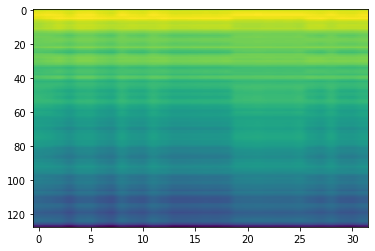

2020-11-08 04:17:33,895 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:16.505875, valid_AUC:0.549684, valid_pAUC:0.505450
100%|██████████| 3452/3452 [00:22<00:00, 150.58it/s]
2020-11-08 04:18:08,115 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:16.691807, valid_AUC:0.547014, valid_pAUC:0.505477
100%|██████████| 3452/3452 [00:21<00:00, 159.77it/s]
2020-11-08 04:18:41,421 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:16.522666, valid_AUC:0.549073, valid_pAUC:0.505792
100%|██████████| 3452/3452 [00:21<00:00, 158.65it/s]
2020-11-08 04:19:14,886 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:16.561934, valid_AUC:0.548911, valid_pAUC:0.506037
100%|██████████| 3452/3452 [00:23<00:00, 149.14it/s]
2020-11-08 04:19:49,521 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:16.601557, valid_AUC:0.547936, valid_pAUC:0.505839
100%|██████████| 3452/3452 [00:24<00:00, 143.47it/s]
2020-11-08 04:20:24,701 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:16.431861, v

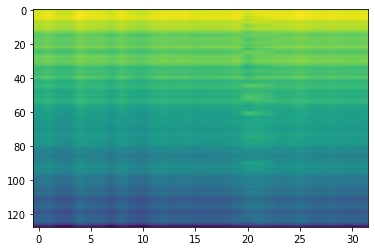

2020-11-08 04:23:18,360 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:16.159232, valid_AUC:0.546845, valid_pAUC:0.506852
100%|██████████| 3452/3452 [00:21<00:00, 158.00it/s]
2020-11-08 04:23:52,495 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:16.152140, valid_AUC:0.550262, valid_pAUC:0.505754
100%|██████████| 3452/3452 [00:22<00:00, 151.30it/s]
2020-11-08 04:24:27,161 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:15.964913, valid_AUC:0.558086, valid_pAUC:0.508277
100%|██████████| 3452/3452 [00:24<00:00, 143.26it/s]
2020-11-08 04:25:02,524 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:15.558545, valid_AUC:0.550351, valid_pAUC:0.504949
100%|██████████| 3452/3452 [00:24<00:00, 140.14it/s]
2020-11-08 04:25:38,035 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:15.560994, valid_AUC:0.537006, valid_pAUC:0.512018
100%|██████████| 3452/3452 [00:24<00:00, 141.12it/s]
2020-11-08 04:26:13,222 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:15.244216, v

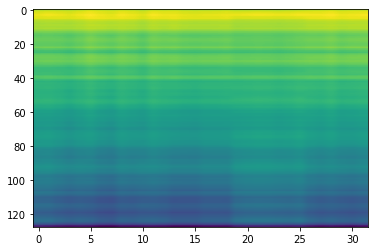

2020-11-08 04:29:03,600 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:14.553801, valid_AUC:0.560299, valid_pAUC:0.505287
100%|██████████| 3452/3452 [00:23<00:00, 145.34it/s]
2020-11-08 04:29:38,446 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:14.537887, valid_AUC:0.559144, valid_pAUC:0.507320
100%|██████████| 3452/3452 [00:24<00:00, 139.75it/s]
2020-11-08 04:30:14,090 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:14.359476, valid_AUC:0.549627, valid_pAUC:0.505999
100%|██████████| 3452/3452 [00:24<00:00, 140.53it/s]
2020-11-08 04:30:49,380 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:14.380984, valid_AUC:0.567031, valid_pAUC:0.506494
100%|██████████| 3452/3452 [00:24<00:00, 142.00it/s]
2020-11-08 04:31:24,417 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:14.451227, valid_AUC:0.546001, valid_pAUC:0.506178
100%|██████████| 3452/3452 [00:23<00:00, 149.20it/s]
2020-11-08 04:31:58,439 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:14.340741, v

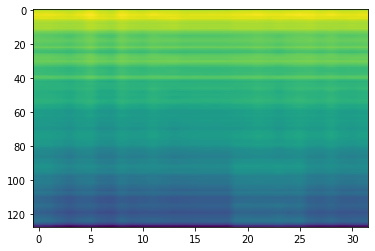

2020-11-08 04:34:49,937 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:14.054699, valid_AUC:0.573185, valid_pAUC:0.510109
100%|██████████| 3452/3452 [00:24<00:00, 140.07it/s]
2020-11-08 04:35:25,638 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:13.968497, valid_AUC:0.573971, valid_pAUC:0.510984
100%|██████████| 3452/3452 [00:24<00:00, 141.81it/s]
2020-11-08 04:36:00,884 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:14.265403, valid_AUC:0.562266, valid_pAUC:0.507153
100%|██████████| 3452/3452 [00:23<00:00, 148.31it/s]
2020-11-08 04:36:35,028 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:14.146645, valid_AUC:0.550928, valid_pAUC:0.509563
100%|██████████| 3452/3452 [00:21<00:00, 157.92it/s]
2020-11-08 04:37:08,358 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:14.263126, valid_AUC:0.572188, valid_pAUC:0.512077
100%|██████████| 3452/3452 [00:21<00:00, 163.17it/s]
2020-11-08 04:37:41,718 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:14.100029, v

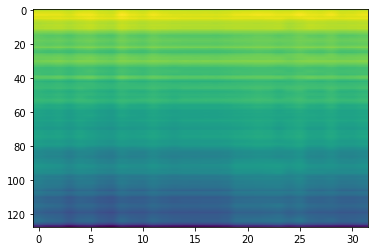

2020-11-08 04:40:37,906 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:13.852705, valid_AUC:0.581847, valid_pAUC:0.510708
100%|██████████| 3452/3452 [00:23<00:00, 147.83it/s]
2020-11-08 04:41:12,156 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:13.707634, valid_AUC:0.574618, valid_pAUC:0.511926
100%|██████████| 3452/3452 [00:22<00:00, 153.26it/s]
2020-11-08 04:41:46,040 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:13.795074, valid_AUC:0.579677, valid_pAUC:0.512671
100%|██████████| 3452/3452 [00:21<00:00, 162.99it/s]
2020-11-08 04:42:19,081 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:13.812327, valid_AUC:0.586940, valid_pAUC:0.512194
100%|██████████| 3452/3452 [00:21<00:00, 158.50it/s]
2020-11-08 04:42:53,026 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:13.811464, valid_AUC:0.584773, valid_pAUC:0.511543
100%|██████████| 3452/3452 [00:23<00:00, 148.68it/s]
2020-11-08 04:43:27,702 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:13.634898, v

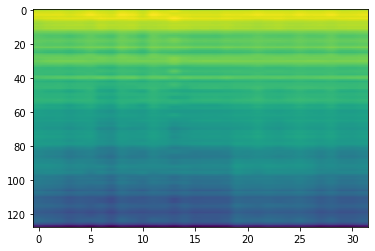

2020-11-08 04:46:22,648 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:13.729168, valid_AUC:0.579741, valid_pAUC:0.512715
100%|██████████| 3452/3452 [00:21<00:00, 160.72it/s]
2020-11-08 04:46:56,289 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:13.711907, valid_AUC:0.589423, valid_pAUC:0.515121
100%|██████████| 3452/3452 [00:21<00:00, 159.19it/s]
2020-11-08 04:47:29,911 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:13.612931, valid_AUC:0.586244, valid_pAUC:0.517154
100%|██████████| 3452/3452 [00:23<00:00, 149.57it/s]
2020-11-08 04:48:04,382 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:13.421851, valid_AUC:0.591425, valid_pAUC:0.519728
100%|██████████| 3452/3452 [00:24<00:00, 140.94it/s]
2020-11-08 04:48:39,961 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:13.244006, valid_AUC:0.589856, valid_pAUC:0.512442
100%|██████████| 3452/3452 [00:24<00:00, 141.94it/s]
2020-11-08 04:49:14,901 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:13.223461, v

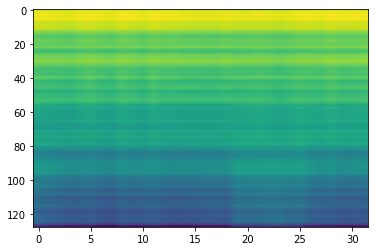

2020-11-08 04:52:05,827 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:13.025057, valid_AUC:0.608586, valid_pAUC:0.518139
100%|██████████| 3452/3452 [00:23<00:00, 148.49it/s]
2020-11-08 04:52:40,556 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:12.815713, valid_AUC:0.605020, valid_pAUC:0.518219
100%|██████████| 3452/3452 [00:24<00:00, 142.48it/s]
2020-11-08 04:53:15,812 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:12.807464, valid_AUC:0.605499, valid_pAUC:0.516914
100%|██████████| 3452/3452 [00:24<00:00, 141.29it/s]
2020-11-08 04:53:51,152 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:12.876524, valid_AUC:0.606095, valid_pAUC:0.520494
100%|██████████| 3452/3452 [00:24<00:00, 142.70it/s]
2020-11-08 04:54:26,334 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:12.808144, valid_AUC:0.607300, valid_pAUC:0.522206
100%|██████████| 3452/3452 [00:23<00:00, 144.92it/s]
2020-11-08 04:55:01,248 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:12.833548, v

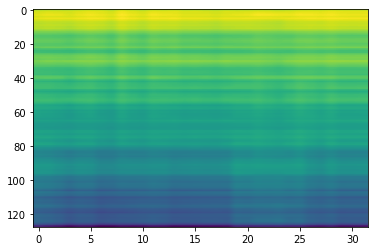

2020-11-08 04:57:51,620 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:12.538286, valid_AUC:0.621048, valid_pAUC:0.521293
2020-11-08 04:57:51,671 - 00_train.py - INFO - 
 success:ToyConveyor 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift_2/models/ToyConveyor_model.pth


elapsed time: 3592.404361486 [sec]


2020-11-08 04:57:52,248 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-08 04:57:52,249 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 04:57:52,251 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 855/855 [00:09<00:00, 90.68it/s]


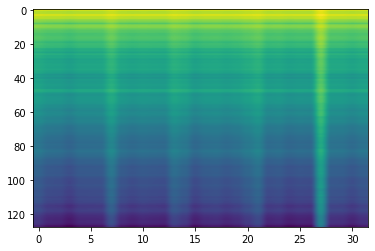

2020-11-08 04:59:09,204 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:143.628458, valid_AUC:0.488093, valid_pAUC:0.490688
100%|██████████| 855/855 [00:05<00:00, 164.25it/s]
2020-11-08 04:59:25,101 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:19.971348, valid_AUC:0.493137, valid_pAUC:0.490833
100%|██████████| 855/855 [00:06<00:00, 130.05it/s]
2020-11-08 04:59:42,766 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:19.630208, valid_AUC:0.498467, valid_pAUC:0.491729
100%|██████████| 855/855 [00:05<00:00, 164.16it/s]
2020-11-08 04:59:58,807 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:19.382277, valid_AUC:0.495500, valid_pAUC:0.491093
100%|██████████| 855/855 [00:05<00:00, 148.37it/s]
2020-11-08 05:00:15,106 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:19.317658, valid_AUC:0.494791, valid_pAUC:0.489965
100%|██████████| 855/855 [00:05<00:00, 145.48it/s]
2020-11-08 05:00:32,565 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:19.267811, valid_AUC:0.4977

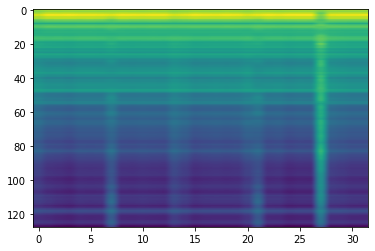

2020-11-08 05:01:38,026 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:15.968714, valid_AUC:0.485747, valid_pAUC:0.491440
100%|██████████| 855/855 [00:06<00:00, 127.61it/s]
2020-11-08 05:01:56,488 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:15.895822, valid_AUC:0.486346, valid_pAUC:0.492770
100%|██████████| 855/855 [00:05<00:00, 163.67it/s]
2020-11-08 05:02:12,413 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:15.592821, valid_AUC:0.477945, valid_pAUC:0.493580
100%|██████████| 855/855 [00:06<00:00, 125.50it/s]
2020-11-08 05:02:29,911 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:15.241364, valid_AUC:0.482258, valid_pAUC:0.496298
100%|██████████| 855/855 [00:05<00:00, 163.85it/s]
2020-11-08 05:02:46,620 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:14.837380, valid_AUC:0.481258, valid_pAUC:0.496443
100%|██████████| 855/855 [00:05<00:00, 163.11it/s]
2020-11-08 05:03:02,338 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:14.781938, valid_AUC:0

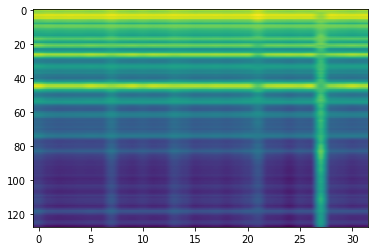

2020-11-08 05:04:26,092 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:13.729788, valid_AUC:0.486016, valid_pAUC:0.497021
100%|██████████| 855/855 [00:06<00:00, 127.04it/s]
2020-11-08 05:04:43,523 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:13.573785, valid_AUC:0.484319, valid_pAUC:0.497166
100%|██████████| 855/855 [00:05<00:00, 163.23it/s]
2020-11-08 05:04:59,907 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.354276, valid_AUC:0.490357, valid_pAUC:0.502863
100%|██████████| 855/855 [00:05<00:00, 163.79it/s]
2020-11-08 05:05:15,637 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:13.125030, valid_AUC:0.495541, valid_pAUC:0.501995
100%|██████████| 855/855 [00:06<00:00, 127.55it/s]
2020-11-08 05:05:33,674 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:12.874461, valid_AUC:0.491033, valid_pAUC:0.501648
100%|██████████| 855/855 [00:05<00:00, 159.94it/s]
2020-11-08 05:05:49,557 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.666418, valid_AUC:0

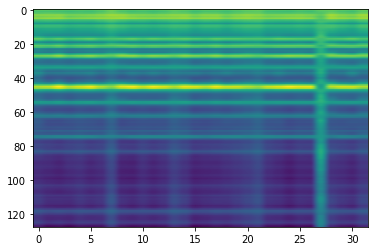

2020-11-08 05:07:12,908 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:12.296716, valid_AUC:0.487198, valid_pAUC:0.501041
100%|██████████| 855/855 [00:05<00:00, 162.23it/s]
2020-11-08 05:07:28,700 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.327213, valid_AUC:0.486786, valid_pAUC:0.502603
100%|██████████| 855/855 [00:06<00:00, 133.30it/s]
2020-11-08 05:07:46,496 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:12.178158, valid_AUC:0.493670, valid_pAUC:0.500925
100%|██████████| 855/855 [00:05<00:00, 163.52it/s]
2020-11-08 05:08:02,445 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:12.076917, valid_AUC:0.492995, valid_pAUC:0.501880
100%|██████████| 855/855 [00:06<00:00, 125.09it/s]
2020-11-08 05:08:19,880 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.859562, valid_AUC:0.495857, valid_pAUC:0.503991
100%|██████████| 855/855 [00:05<00:00, 164.19it/s]
2020-11-08 05:08:36,645 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.939864, valid_AUC:0

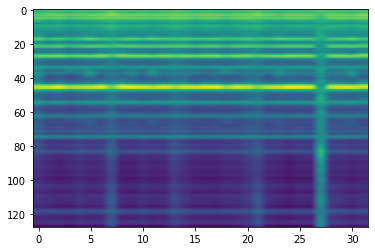

2020-11-08 05:10:00,478 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.484903, valid_AUC:0.504055, valid_pAUC:0.501533
100%|██████████| 855/855 [00:05<00:00, 163.12it/s]
2020-11-08 05:10:16,253 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.550691, valid_AUC:0.500418, valid_pAUC:0.501619
100%|██████████| 855/855 [00:06<00:00, 123.34it/s]
2020-11-08 05:10:34,138 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.454334, valid_AUC:0.503874, valid_pAUC:0.501446
100%|██████████| 855/855 [00:05<00:00, 165.32it/s]
2020-11-08 05:10:50,411 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.459491, valid_AUC:0.508516, valid_pAUC:0.502111
100%|██████████| 855/855 [00:05<00:00, 164.03it/s]
2020-11-08 05:11:06,239 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.276206, valid_AUC:0.508772, valid_pAUC:0.501041
100%|██████████| 855/855 [00:06<00:00, 136.44it/s]
2020-11-08 05:11:24,307 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.251113, valid_AUC:0

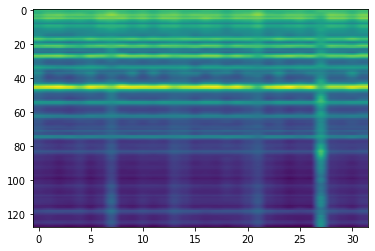

2020-11-08 05:12:48,225 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.903259, valid_AUC:0.520637, valid_pAUC:0.500405
100%|██████████| 855/855 [00:05<00:00, 164.59it/s]
2020-11-08 05:13:04,203 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.869368, valid_AUC:0.529033, valid_pAUC:0.500810
100%|██████████| 855/855 [00:05<00:00, 147.29it/s]
2020-11-08 05:13:20,739 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.830771, valid_AUC:0.526560, valid_pAUC:0.501157
100%|██████████| 855/855 [00:05<00:00, 158.81it/s]
2020-11-08 05:13:38,049 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.730443, valid_AUC:0.532330, valid_pAUC:0.500781
100%|██████████| 855/855 [00:05<00:00, 159.68it/s]
2020-11-08 05:13:53,811 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.837739, valid_AUC:0.529747, valid_pAUC:0.501215
100%|██████████| 855/855 [00:06<00:00, 128.18it/s]
2020-11-08 05:14:11,266 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.802669, valid_AUC:0

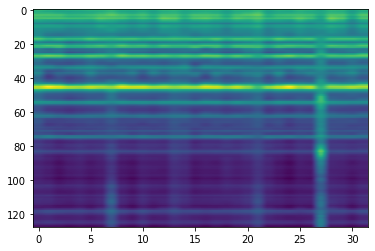

2020-11-08 05:15:34,360 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.550640, valid_AUC:0.548456, valid_pAUC:0.501909
100%|██████████| 855/855 [00:05<00:00, 159.15it/s]
2020-11-08 05:15:51,475 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.516136, valid_AUC:0.540228, valid_pAUC:0.501909
100%|██████████| 855/855 [00:05<00:00, 164.19it/s]
2020-11-08 05:16:07,189 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.501641, valid_AUC:0.539484, valid_pAUC:0.502689
100%|██████████| 855/855 [00:06<00:00, 124.13it/s]
2020-11-08 05:16:25,178 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.408369, valid_AUC:0.539110, valid_pAUC:0.503268
100%|██████████| 855/855 [00:05<00:00, 163.82it/s]
2020-11-08 05:16:41,429 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.426231, valid_AUC:0.537923, valid_pAUC:0.501764
100%|██████████| 855/855 [00:05<00:00, 158.86it/s]
2020-11-08 05:16:57,373 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.375649, valid_AUC:0

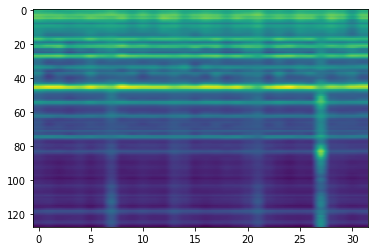

2020-11-08 05:18:20,620 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.318422, valid_AUC:0.539423, valid_pAUC:0.504106
100%|██████████| 855/855 [00:06<00:00, 126.22it/s]
2020-11-08 05:18:38,945 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.272514, valid_AUC:0.539253, valid_pAUC:0.501822
100%|██████████| 855/855 [00:05<00:00, 163.14it/s]
2020-11-08 05:18:54,804 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.317540, valid_AUC:0.546148, valid_pAUC:0.503904
100%|██████████| 855/855 [00:06<00:00, 137.83it/s]
2020-11-08 05:19:11,546 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.182332, valid_AUC:0.540253, valid_pAUC:0.501822
100%|██████████| 855/855 [00:05<00:00, 160.45it/s]
2020-11-08 05:19:28,427 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.178255, valid_AUC:0.544011, valid_pAUC:0.502313
100%|██████████| 855/855 [00:05<00:00, 164.63it/s]
2020-11-08 05:19:43,905 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.209196, valid_AUC:0

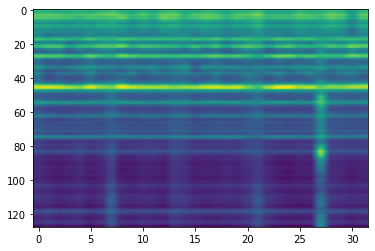

2020-11-08 05:21:07,781 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.047538, valid_AUC:0.547110, valid_pAUC:0.501706
100%|██████████| 855/855 [00:06<00:00, 133.77it/s]
2020-11-08 05:21:24,812 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.086428, valid_AUC:0.551275, valid_pAUC:0.502516
100%|██████████| 855/855 [00:05<00:00, 163.70it/s]
2020-11-08 05:21:41,258 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.065740, valid_AUC:0.550456, valid_pAUC:0.500260
100%|██████████| 855/855 [00:05<00:00, 164.12it/s]
2020-11-08 05:21:57,146 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.015239, valid_AUC:0.551940, valid_pAUC:0.500087
100%|██████████| 855/855 [00:06<00:00, 122.91it/s]
2020-11-08 05:22:15,202 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:9.968283, valid_AUC:0.551714, valid_pAUC:0.501070
100%|██████████| 855/855 [00:05<00:00, 158.89it/s]
2020-11-08 05:22:31,301 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:9.964758, valid_AUC:0.5

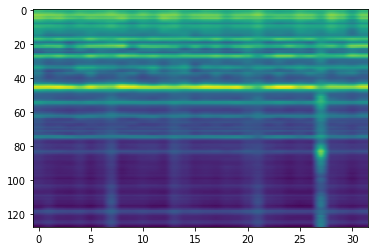

2020-11-08 05:23:55,112 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:9.904281, valid_AUC:0.547011, valid_pAUC:0.501822
100%|██████████| 855/855 [00:05<00:00, 163.29it/s]
2020-11-08 05:24:11,027 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:9.845213, valid_AUC:0.541984, valid_pAUC:0.501301
100%|██████████| 855/855 [00:06<00:00, 130.43it/s]
2020-11-08 05:24:29,091 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:9.745125, valid_AUC:0.551181, valid_pAUC:0.500607
100%|██████████| 855/855 [00:05<00:00, 163.33it/s]
2020-11-08 05:24:44,759 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:9.836314, valid_AUC:0.556165, valid_pAUC:0.502805
100%|██████████| 855/855 [00:05<00:00, 156.62it/s]
2020-11-08 05:25:00,682 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:9.712572, valid_AUC:0.554143, valid_pAUC:0.502140
100%|██████████| 855/855 [00:05<00:00, 155.79it/s]
2020-11-08 05:25:17,832 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:9.722673, valid_AUC:0.55659

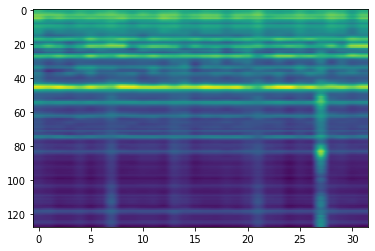

2020-11-08 05:26:46,391 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:9.595556, valid_AUC:0.555198, valid_pAUC:0.502227
2020-11-08 05:26:46,444 - 00_train.py - INFO - 
 success:valve 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE_window_shift_2/models/valve_model.pth


elapsed time: 1734.197298527 [sec]


In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)